In [16]:
using CSV, FileIO, DataFrames, Dates
using Plots, StatsPlots

In [25]:
region="italy"
catalog="INGV"
mkpath("./results/$region/")

"./results/italy"

In [29]:
df = CSV.read("./data/$region.csv", DataFrame)

Row,Datetime,Latitude,Longitude,Depth,Magnitude_Type,Magnitude
,DateTime,Float64,Float64,Float64,String7,Float64
1,1985-01-02T18:39:30.740,48.092,7.061,10.0,M,4.0
2,1985-01-02T22:57:43.090,41.715,13.941,5.8,Md,2.6
3,1985-01-03T00:46:16.990,41.677,13.931,6.1,Md,2.5
4,1985-01-04T16:57:40.240,46.158,7.174,10.0,M,3.8
5,1985-01-04T23:59:54.820,45.338,6.641,5.0,M,3.7
6,1985-01-05T03:47:03.640,45.409,6.627,10.0,M,3.2
7,1985-01-05T08:32:41.900,43.056,13.139,2.8,Md,2.6
8,1985-01-05T10:13:26.800,45.15,7.86,20.8,Md,2.2
9,1985-01-05T13:06:33.110,42.62,22.312,10.0,M,4.5


In [30]:
# Using describe function to get statistics of a dataset
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Datetime,,1985-01-02T18:39:30.740,2015-05-11T22:01:58.240,2023-03-08T11:05:17.900,0,DateTime
2,Latitude,42.2295,-69.757,42.8268,84.3258,0,Float64
3,Longitude,13.3849,-179.99,13.1407,179.939,0,Float64
4,Depth,12.8846,0.0,10.0,675.4,0,Float64
5,Magnitude_Type,,M,,mb,0,String7
6,Magnitude,1.58785,0.1,1.4,9.0,0,Float64


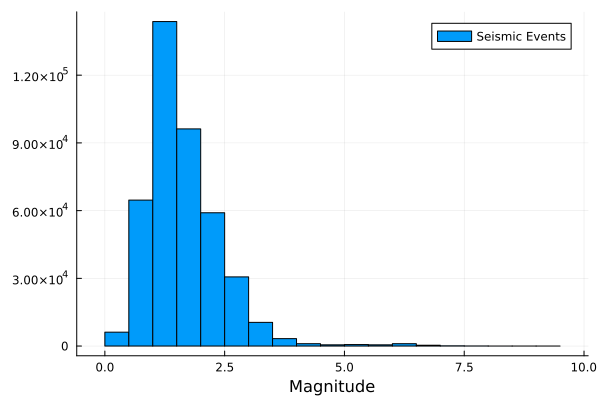

In [32]:
fig = Plots.histogram(df[:,:Magnitude],
                    bins = 40, xlabel = "Magnitude", label="Seismic Events")

savefig("./results/$region/histogram_events_magnitudes.png")
fig

In [33]:
function join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold)
	#######################################################
	# Get all counts for all years (no magnitude bounds)
	#######################################################

	# Trims the dataframe by year
	df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(df.Magnitude .> magnitude_threshold),:]

	# Extracts just the year and puts it in the dataframe
	df_transformed = transform(df_trimmed, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year
	df_counted = combine(groupby(df_transformed, :Year), nrow => Symbol("count"));

	return df_counted
end
	

join_on_counted_no_mag_bounds (generic function with 1 method)

In [34]:
function join_on_counted(df,trim_year,minmag,maxmag)
	#######################################################
	# Get all counts for all years and magnitude thresholds
	#######################################################
	
	# Trims the dataframe by year and magnitude threshold
	df_trimmed_mag = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .& 
						  (df.Magnitude .>= minmag) .&
						  (df.Magnitude .< maxmag),:]
	
	# Extracts just the year and puts it in the dataframe
	df_transformed_mag = transform(df_trimmed_mag, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year per magnitude
	df_counted_mag = combine(groupby(df_transformed_mag, :Year), nrow => Symbol("count_mag_$minmag"));

	# return outerjoin(df_counted, df_counted_mag, on= :Year)
	return df_counted_mag
end

join_on_counted (generic function with 1 method)

In [35]:
trim_year = 1985
magnitude_threshold = 0.0;

In [36]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

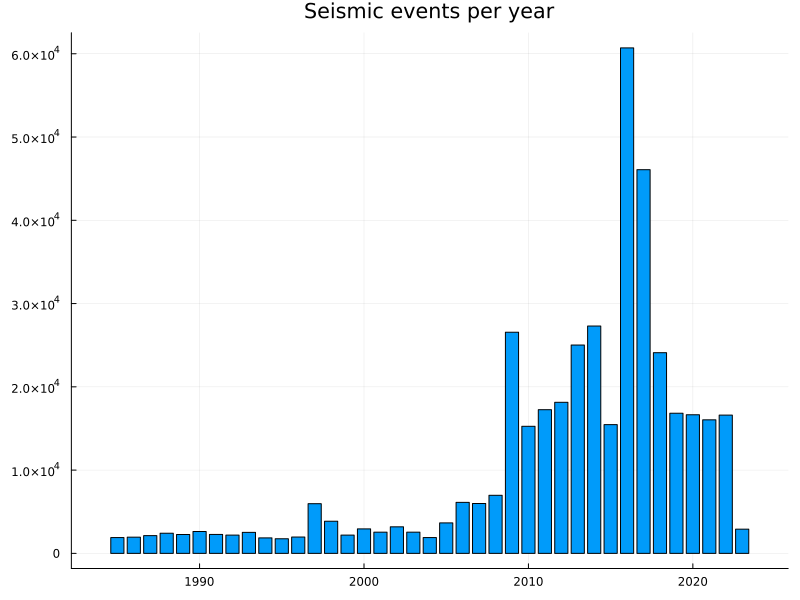

In [37]:
fig = bar(df_counted.Year, df_counted.count, 
	orientation=:vertical, 
	title="Seismic events per year",
    legend=false)
	# label="Seismic Events")
StatsPlots.plot!(size=(800,600))

# # Inset plot
# # Select from 1976 onwards 
# bar!(df_counted.Year[end-46:end], df_counted.count[end-46:end], 
# 	orientation=:vertical,
#     inset = bbox(0.1, 0.1, 0.5, 0.5, :top, :left), 
#     label="starting with 1976",
#     # ticks = nothing,
#     yticks = nothing,
#     subplot = 2,
#     bg_inside = nothing)
# 	# label="Seismic Events")


savefig("./results/$region/events_per_year.png")
fig

In [38]:
trim_year = 1985
magnitude_threshold = 0.0;

In [39]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

In [40]:
for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	maxmag=minmag+1
	df_counted_mag_extra = join_on_counted(df,trim_year,minmag,maxmag)

	leftjoin!(df_counted, df_counted_mag_extra, on=:Year,makeunique=true)
	df_counted[!,Symbol("count_mag_$minmag")] = replace(df_counted[!,Symbol("count_mag_$minmag")], missing => 0)
end

In [41]:
df_counted

Row,Year,count,count_mag_0,count_mag_1,count_mag_2,count_mag_3,count_mag_4,count_mag_5,count_mag_6,count_mag_7,count_mag_8,count_mag_9
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1985,1894,0,32,1324,458,72,8,0,0,0,0
2,1986,1944,0,38,1366,480,58,2,0,0,0,0
3,1987,2128,0,62,1702,343,20,1,0,0,0,0
4,1988,2420,0,68,1850,473,26,3,0,0,0,0
5,1989,2263,0,146,1658,425,33,1,0,0,0,0
6,1990,2624,0,74,2034,470,40,6,0,0,0,0
7,1991,2270,0,56,1788,398,26,2,0,0,0,0
8,1992,2190,0,101,1675,381,33,0,0,0,0,0
9,1993,2524,0,134,1925,438,26,1,0,0,0,0


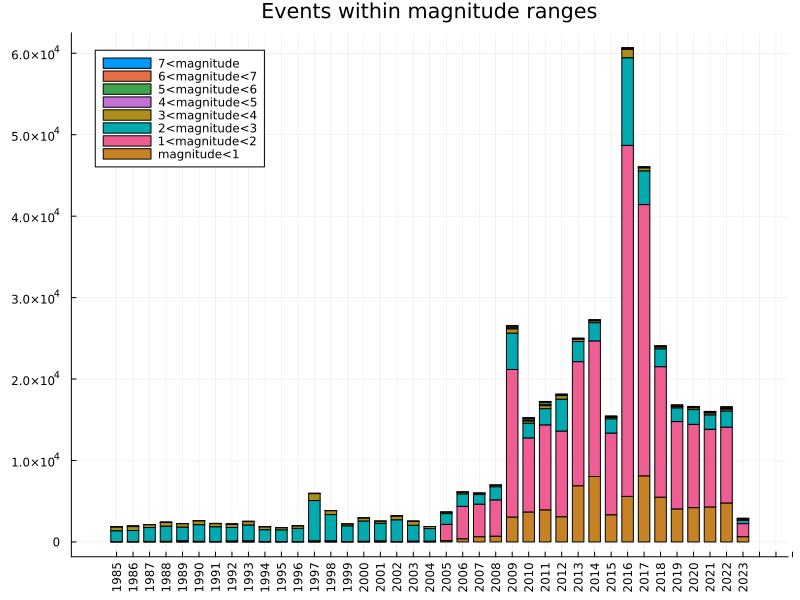

In [42]:

mags=[]
for minmag=0:7
	push!(mags,df_counted[!,Symbol("count_mag_$minmag")])
end

ticklabels = string.(collect(minimum(df_counted.Year):maximum(df_counted.Year)))

fig = groupedbar([ mags[8] mags[7] mags[6] mags[5] mags[4] mags[3] mags[2] mags[1] ],
			bar_position = :stack,
			bar_width=0.7,
			xticks=(1:46, ticklabels),
			xrotation=90,
			title="Events within magnitude ranges",
			label=["7<magnitude" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" "1<magnitude<2" "magnitude<1"])

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags.png")
fig


In [43]:
# Test to check if all quakes have been properly placed in magnitude bracket 
quakes=0
for minmag=0:7
	quakes+= sum(df_counted[!,Symbol("count_mag_$minmag")])
end
quakes == sum(df_counted[!,:count])

false

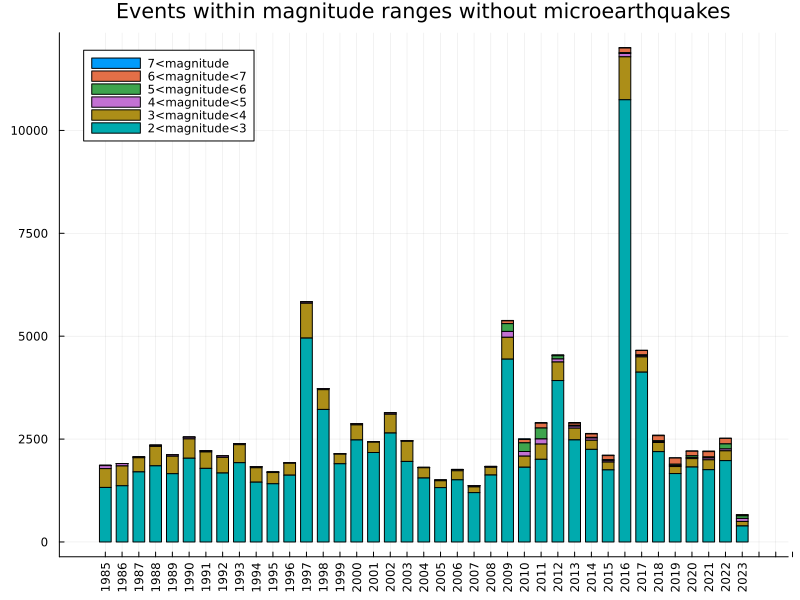

In [44]:

fig = groupedbar([ mags[8] mags[7] mags[6] mags[5] mags[4] mags[3]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:46, ticklabels),
				xrotation=90,
				title="Events within magnitude ranges without microearthquakes",
				label=["7<magnitude" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" ]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags_no_microearthquakes.png")
fig


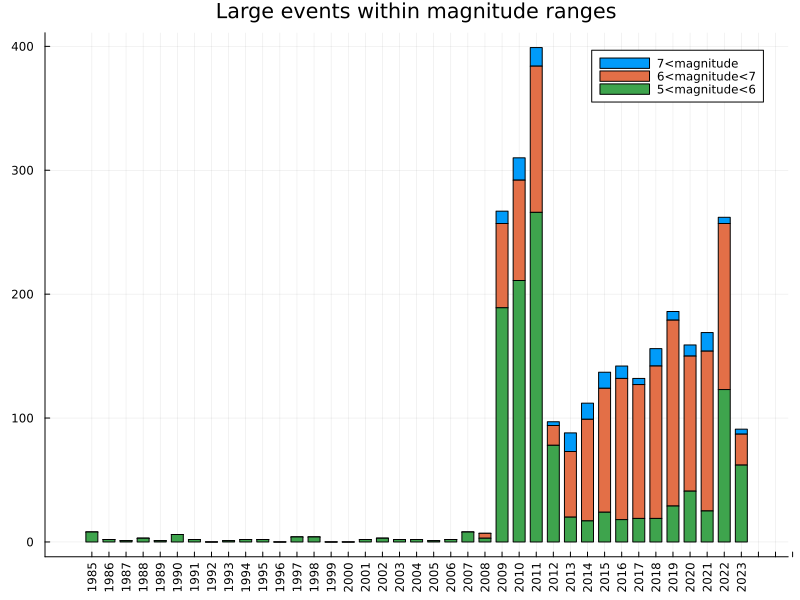

In [45]:
fig = groupedbar([ mags[8] mags[7] mags[6]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:46, ticklabels),
				xrotation=90,
				title="Large events within magnitude ranges",
				label=["7<magnitude" "6<magnitude<7" "5<magnitude<6"]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags_large.png")
fig

In [46]:
using GLMakie, CairoMakie

In [47]:
# Theme
seismic_theme = Theme(
    # fontsize = 24,
    Axis3 = (
        xlabelsize = 24,
        xlabeloffset = 40,
        xticklabelsize  = 16,

        ylabelsize = 24,
        ylabeloffset = 40,
        yticklabelsize  = 16,

        zlabelsize = 24,
        zlabeloffset = 60,
        zticklabelsize  = 16
        )
                    );

In [48]:
function seismic_scatter_2D(region, trim_year, magnitude_threshold, with_image, img=nothing)
	
	CairoMakie.activate!()
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	fig = Figure( resolution=(1080, 720))
	ax = Axis(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude",
	)

	markerSizes = [1.7^x for x in region.Magnitude];

	limits!(mapcoords["minLon"], mapcoords["maxLon"], mapcoords["minLat"], mapcoords["maxLat"])
	
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		CairoMakie.image!( 
				range(mapcoords["minLon"],mapcoords["maxLon"],step=0.01),
				range(mapcoords["minLat"],mapcoords["maxLat"],step=0.01),
			    rotr90(img*0.55);
				)
	end

	sc = CairoMakie.scatter!(ax, region.Longitude, region.Latitude,
	    markersize= markerSizes,
		markeralpha = region.Depth,
	    color= region.Magnitude,
	    colormap= (Reverse(:devon), 1),
	    strokewidth= 0.5,
	    shading= false
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))

	return fig
end

seismic_scatter_2D (generic function with 2 methods)

In [49]:
function seismic_scatter_3D(region, trim_year, magnitude_threshold, with_image, img=nothing)
	GLMakie.activate!()
	set_theme!(seismic_theme)
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
		            "minDepth"=>minimum(region.Depth),
		            "maxDepth"=>maximum(region.Depth),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	mapcoords["maxDepth"]=maximum(region.Depth)

	fig = Figure( resolution=(1080, 720))

	# scene = Scene(resolution = (600, 400))
	# scale!(scene, 1, 2, 2)

	# lscene = LScene(fig[1, 1])
	# # surface!(lscene, ...)
	
	# cam = cameracontrols(lscene.scene)
	# cam.lookat[] = [0, 0, 200]
	# cam.eyeposition[] = [3000, 200, 2000]
	# update_cam!(lscene.scene, cam)

	# parent = Scene(backgroundcolor=:white)
	# cam3d!(parent)

	# camc = cameracontrols(parent)
	# update_cam!(parent, camc, Vec3f(0, 0, 0), Vec3f(4.0, 0, 0))
	
	# cam = Makie.camera(scene)
	
	ax = Axis3(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude", zlabel = "Depth",
		# viewmode = :fit,
	    perspectiveness=0.5,
		aspect=(1.3, 1, 0.5)
	)
	# scale!(ax.scene,1.0,1.0,0.7)
	
	markerSizes = [1.7^x for x in region.Magnitude];
	
	sc = GLMakie.scatter!(ax, region.Longitude, region.Latitude, -region.Depth;
		markersize= markerSizes,
		color= region.Magnitude,
		colormap= (Reverse(:devon), 0.99),
		strokewidth= 0.5,
		shading= false,
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		image!(ax , 
				mapcoords["minLon"] .. mapcoords["maxLon"],
				mapcoords["minLat"] .. mapcoords["maxLat"],

				# range(mapcoords["minLon"],mapcoords["maxLon"],step=0.01),
				# range(mapcoords["minLat"],mapcoords["maxLat"],step=0.01),
			    rotr90(img*0.7); 
			    transformation=(:xy,10)# -mapcoords["maxDepth"]),
				)
	end

    return fig
end

seismic_scatter_3D (generic function with 2 methods)

In [ ]:
# img_path = "./maps/romania_wikipedia.png"
# img = load(img_path);

### Without image

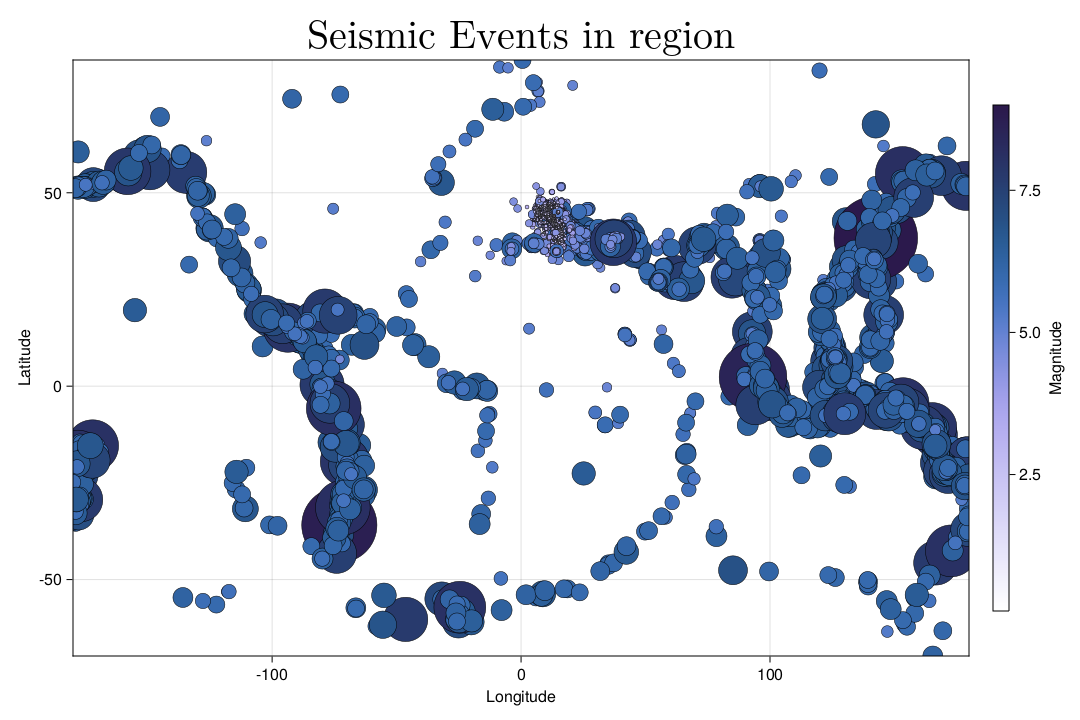

In [50]:
fig = seismic_scatter_2D(df, trim_year, magnitude_threshold, false, nothing)
save("./results/$region/2D_mag_$magnitude_threshold.png", fig)
fig

## Italy

In [51]:
italy = df[(df.Longitude .>= 6.6166 ) .& (df.Longitude .<= 18.5166) .&
				  (df.Latitude .>=35.5) .& (df.Latitude .<= 47.0833) ,:]

Row,Datetime,Latitude,Longitude,Depth,Magnitude_Type,Magnitude
,DateTime,Float64,Float64,Float64,String7,Float64
1,1985-01-02T22:57:43.090,41.715,13.941,5.8,Md,2.6
2,1985-01-03T00:46:16.990,41.677,13.931,6.1,Md,2.5
3,1985-01-04T16:57:40.240,46.158,7.174,10.0,M,3.8
4,1985-01-04T23:59:54.820,45.338,6.641,5.0,M,3.7
5,1985-01-05T03:47:03.640,45.409,6.627,10.0,M,3.2
6,1985-01-05T08:32:41.900,43.056,13.139,2.8,Md,2.6
7,1985-01-05T10:13:26.800,45.15,7.86,20.8,Md,2.2
8,1985-01-06T03:52:23.380,43.357,12.537,10.0,Md,2.4
9,1985-01-06T04:19:36.650,43.37,12.545,10.0,Md,2.3


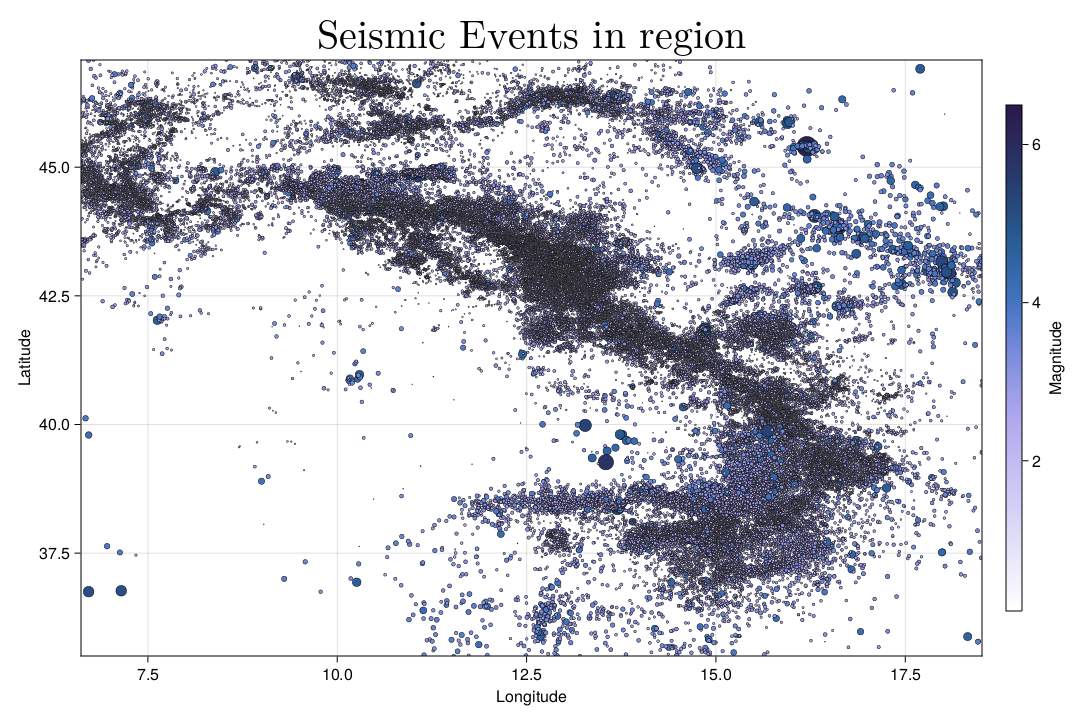

In [52]:
fig = seismic_scatter_2D(italy, trim_year, magnitude_threshold, false, nothing)
save("./results/$region/italy_2D_mag_$magnitude_threshold.png", fig)
fig

In [ ]:
fig = seismic_scatter_3D(df, trim_year, magnitude_threshold, false, nothing)
save("./results/$region/3D_mag_$magnitude_threshold.png", fig)
fig